# Neural Network SMS Text Classifier

---
In this challenge, I have to build a neural network machine learning model to classify SMS messages as either "ham" or "spam" from the given dataset.



> - This project represents a submission for the "[Machine Learning with Python](https://www.freecodecamp.org/learn/machine-learning-with-python)" course by freeCodeCamp.


> - The "Neural Network SMS Text Classifier" challenge link is [here](https://www.freecodecamp.org/learn/machine-learning-with-python/machine-learning-with-python-projects/neural-network-sms-text-classifier).


```
Nattawut Chamcheun (Friend)
Date: 29-08-2023
```

# Preparation

In [ ]:
# import libraries
try:
  # %tensorflow_version only exists in Colab.
  !pip install tf-nightly
except Exception:
  pass
import tensorflow as tf
import pandas as pd
from tensorflow import keras
!pip install tensorflow-datasets
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

In [2]:
# get data files
!wget https://cdn.freecodecamp.org/project-data/sms/train-data.tsv
!wget https://cdn.freecodecamp.org/project-data/sms/valid-data.tsv

train_file_path = "train-data.tsv"
test_file_path = "valid-data.tsv"

--2023-08-29 05:57:33--  https://cdn.freecodecamp.org/project-data/sms/train-data.tsv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.2.33, 104.26.3.33, 172.67.70.149, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.2.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 358233 (350K) [text/tab-separated-values]
Saving to: ‘train-data.tsv’

train-data.tsv      100%[===================>] 349.84K  --.-KB/s    in 0.006s  

2023-08-29 05:57:33 (58.4 MB/s) - ‘train-data.tsv’ saved [358233/358233]

--2023-08-29 05:57:33--  https://cdn.freecodecamp.org/project-data/sms/valid-data.tsv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.2.33, 104.26.3.33, 172.67.70.149, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.2.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 118774 (116K) [text/tab-separated-values]
Saving to: ‘valid-data.tsv’

valid-data.tsv      100%[==============

## Import the Data

In [106]:
column_names = ['label', 'message']
train_data = pd.read_csv(train_file_path, sep="\t", names=column_names)
train_data.head()

,label,message
0,ham,ahhhh...just woken up!had a bad dream about u ...
1,ham,you can never do nothing
2,ham,"now u sound like manky scouse boy steve,like! ..."
3,ham,mum say we wan to go then go... then she can s...
4,ham,never y lei... i v lazy... got wat? dat day ü ...


In [107]:
test_data = pd.read_csv(test_file_path, sep="\t", names=column_names)
test_data.head()

,label,message
0,ham,i am in hospital da. . i will return home in e...
1,ham,"not much, just some textin'. how bout you?"
2,ham,i probably won't eat at all today. i think i'm...
3,ham,don‘t give a flying monkeys wot they think and...
4,ham,who are you seeing?


In [215]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4179 entries, 0 to 4178
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    4179 non-null   object
 1   message  4179 non-null   object
dtypes: object(2)
memory usage: 65.4+ KB


In [216]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1392 entries, 0 to 1391
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    1392 non-null   object
 1   message  1392 non-null   object
dtypes: object(2)
memory usage: 21.9+ KB


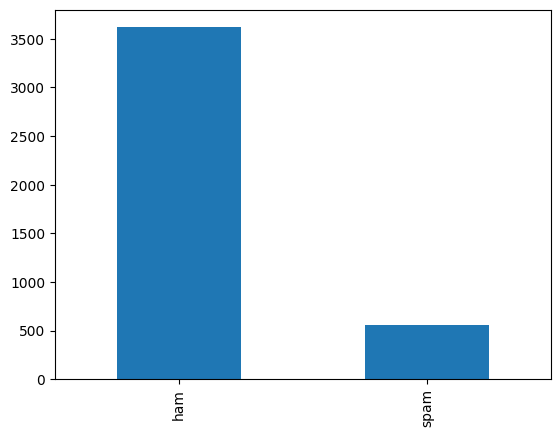

In [214]:
## See the overview of the data in visual

train_data['label'].value_counts().plot.bar();

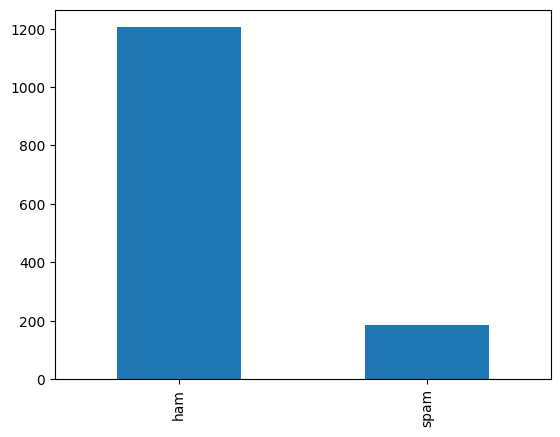

In [109]:
test_data['label'].value_counts().plot.bar();

## Undersampling

Since our data is in imbalance state. We will solve this problem with undersampling method.

In [110]:
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

# Split data into features (X) and labels (y)
X_train = train_data["message"]
y_train = train_data["label"]

X_test = test_data["message"]
y_test = test_data["label"]

# Perform undersampling on the training set
under_sampler = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = under_sampler.fit_resample(X_train.to_frame(), y_train)

X_train_resampled = X_train_resampled.squeeze()

# Check the class distribution after undersampling
print("Class distribution after undersampling (train dataset):", Counter(y_train_resampled))

Class distribution after undersampling (train dataset): Counter({'ham': 560, 'spam': 560})


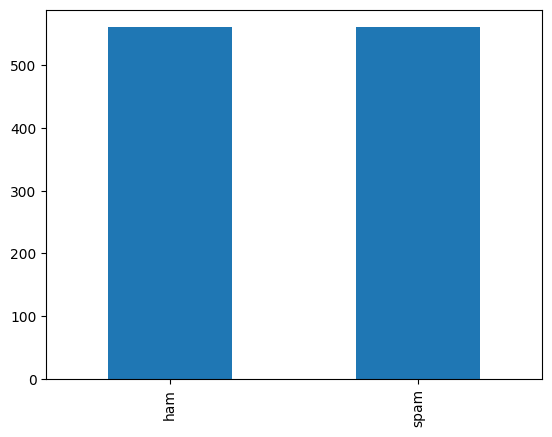

In [213]:
# See our resampled data in visual

y_train_resampled.value_counts().plot.bar();

## Data Transformation

In [142]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# Tokenize text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train_resampled)

train_sequences = tokenizer.texts_to_sequences(X_train_resampled)
test_sequences = tokenizer.texts_to_sequences(X_test)

# Pad sequences
max_sequence_length = max(max(len(sequence) for sequence in train_sequences), max(len(sequence) for sequence in test_sequences))
padded_train_sequences = pad_sequences(train_sequences, maxlen=max_sequence_length, padding="post")
padded_test_sequences = pad_sequences(test_sequences, maxlen=max_sequence_length, padding="post")

In [143]:
# Convert labels to numerical labels
label_mapping = {label: index for index, label in enumerate(train_data["label"].unique())}
train_numerical_labels = y_train_resampled.map(label_mapping)
test_numerical_labels = y_test.map(label_mapping)

# Build the Model

In [199]:
## Construct the model's layers

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=128, input_length=max_sequence_length))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)))
model.add(tf.keras.layers.Dense(1, activation="sigmoid"))

In [200]:
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [201]:
## See the model summary

model.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_21 (Embedding)    (None, 189, 128)          520320    
                                                                 
 bidirectional_5 (Bidirecti  (None, 128)               98816     
 onal)                                                           
                                                                 
 dense_20 (Dense)            (None, 1)                 129       
                                                                 
Total params: 619265 (2.36 MB)
Trainable params: 619265 (2.36 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [202]:
## Train the model

model.fit(padded_train_sequences, train_numerical_labels, validation_data=(padded_test_sequences, test_numerical_labels), epochs=5, batch_size=32)

Epoch 1/5
35/35 [==============================] - 18s 367ms/step - loss: 0.5565 - accuracy: 0.7482 - val_loss: 0.3522 - val_accuracy: 0.8499
Epoch 2/5
35/35 [==============================] - 18s 519ms/step - loss: 0.1937 - accuracy: 0.9366 - val_loss: 0.1654 - val_accuracy: 0.9591
Epoch 3/5
35/35 [==============================] - 14s 405ms/step - loss: 0.0664 - accuracy: 0.9821 - val_loss: 0.1123 - val_accuracy: 0.9655
Epoch 4/5
35/35 [==============================] - 10s 275ms/step - loss: 0.0246 - accuracy: 0.9955 - val_loss: 0.0763 - val_accuracy: 0.9799
Epoch 5/5
35/35 [==============================] - 12s 345ms/step - loss: 0.0123 - accuracy: 0.9982 - val_loss: 0.0721 - val_accuracy: 0.9813


## Evaluate the model

In [203]:
## Evaluate on the test data
loss, accuracy = model.evaluate(padded_test_sequences, test_numerical_labels)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

44/44 [==============================] - 3s 58ms/step - loss: 0.0721 - accuracy: 0.9813
Test Loss: 0.0721, Test Accuracy: 0.9813


# Submission

In [211]:
# function to predict messages based on model
# (should return list containing prediction and label, ex. [0.008318834938108921, 'ham'])

def predict_message(pred_text):
    # Ensure messages is a list, even for a single message
    if not isinstance(pred_text, list):
        pred_text = [pred_text]

    # Tokenize and pad the input messages
    sequences = tokenizer.texts_to_sequences(pred_text)
    padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length, padding="post")

    # Make predictions
    predictions = model.predict(padded_sequences)

    # Convert probability scores to predicted labels (0 or 1)
    predicted_labels = (predictions > 0.5).astype(int)

    # Return a list of [probability, label] for each message
    results = [[float(prediction), "spam" if label == 1 else "ham"] for prediction, label in zip(predictions, predicted_labels)]

    # If there is only one element in the result list, return only that element
    if len(results) == 1:
      result = results[0]
    else:
      result = results

    return result

pred_text = "how are you doing today?"

prediction = predict_message(pred_text)
print(prediction)

1/1 [==============================] - 0s 91ms/step
[0.0053630368784070015, 'ham']


In [212]:
# Run this cell to test your function and model. Do not modify contents.
def test_predictions():
  test_messages = ["how are you doing today",
                   "sale today! to stop texts call 98912460324",
                   "i dont want to go. can we try it a different day? available sat",
                   "our new mobile video service is live. just install on your phone to start watching.",
                   "you have won £1000 cash! call to claim your prize.",
                   "i'll bring it tomorrow. don't forget the milk.",
                   "wow, is your arm alright. that happened to me one time too"
                  ]

  test_answers = ["ham", "spam", "ham", "spam", "spam", "ham", "ham"]
  passed = True

  for msg, ans in zip(test_messages, test_answers):
    print(ans)
    prediction = predict_message(msg)
    print(prediction)
    if prediction[1] != ans:
      passed = False

  if passed:
    print("You passed the challenge. Great job!")
  else:
    print("You haven't passed yet. Keep trying.")

test_predictions()


ham
1/1 [==============================] - 0s 90ms/step
[0.0053630368784070015, 'ham']
spam
1/1 [==============================] - 0s 106ms/step
[0.6308251619338989, 'spam']
ham
1/1 [==============================] - 0s 96ms/step
[0.002444487763568759, 'ham']
spam
1/1 [==============================] - 0s 87ms/step
[0.9890956282615662, 'spam']
spam
1/1 [==============================] - 0s 95ms/step
[0.9961050152778625, 'spam']
ham
1/1 [==============================] - 0s 87ms/step
[0.0026330924592912197, 'ham']
ham
1/1 [==============================] - 0s 84ms/step
[0.006858247797936201, 'ham']
You passed the challenge. Great job!
